### Feature Selection
##### 7개 군집의 주요 feature 가 뭔지 보기

- feature selection model :  Recursive Feature Elimination
- linear model : SVR
- X: X_scaler
- y : cluster_label (7개 군집)


In [1]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
isee_machine_operation = pd.read_csv('./data/isee_machine_operation_file21.csv')

In [4]:
isee_machine_operation = isee_machine_operation[isee_machine_operation['Operation_label']==1]

In [3]:
isee_machine_operation.columns

Index(['ModuleCount', 'creationTime', 'CycleTime', 'VpPosition', 'VpTime',
       'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
       'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
       'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
       'Zone1', 'Zone2', 'Zone3', 'Zone4', 'creationDate', 'Time', 'ampm',
       '機台號', '拉長', '工單號', '產品編號', '產品名稱', '模號', 'CycleNum',
       'creationTime_diff', 'Operation_label', 'True_label'],
      dtype='object')

In [5]:
isee_machine_operation.shape

(211572, 32)

In [35]:
# #### for DBSCAN
# isee_machine_operation = isee_machine_operation.drop(['Cluster_label'], axis=1)
# isee_machine_operation = isee_machine_operation.rename(columns={'predict':'Cluster_label'})

### ReLableing
- Cluster_label > 정상/ 비정상
- faulty_cluster : 비정상으로 label한 군집 번호

In [43]:
# 5 > 비정상 / 나머지 정상
faulty_cluster = 4

isee_machine_operation['Cluster_relabel'] = isee_machine_operation['Cluster_label']
label = ['Y' if isee_machine_operation['Cluster_label'][i] == faulty_cluster else 'N' for i in range(isee_machine_operation.shape[0])]
isee_machine_operation['Cluster_relabel'] = label

### Recursive Feature Elimination
- RFE와 RFECV는 교차검증 하냐 안하냐 차이
- 결과적으로 차이 없어보임

In [9]:
X_all = isee_machine_operation[[ 'CycleTime', 'VpPosition', 'VpTime',
       'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
       'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
       'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
       'Zone1', 'Zone2', 'Zone3', 'Zone4']]
cols = np.array(X_all.columns)

X_scaler = StandardScaler().fit_transform(X_all)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [45]:
# Cluster_relabel >  정상/비정상
y = isee_machine_operation['Cluster_relabel']

In [46]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)

In [47]:
# features_to_select = 5
selector = RFE(clf, n_features_to_select = 5, step=1)
selector = selector.fit(X_scaler, y)

In [48]:
rfe_cols = list(cols[selector.support_.tolist()])
rfe_cols

['CycleTime',
 'VpPressure',
 'MaxInjectionPressure',
 'PlasticizingTime',
 'PlasticsEndPosotion']

In [21]:
# ** 오래걸림 주의 (5분정도)
# min_features_to_select=5 최소 5개 이상 선택
selector_rfecv = RFECV(clf, step=1, cv=5,min_features_to_select= 5)
selector_rfecv = selector_rfecv.fit(X_scaler, y)

In [22]:
rfecv_cols = list(cols[selector_rfecv.support_.tolist()])
rfecv_cols

['CycleTime',
 'VpPosition',
 'VpTime',
 'VpPressure',
 'MaxInjectionPressure',
 'PlasticsEndPosotion',
 'TankTemp',
 'Zone1']

### 산점도 행렬 그려보기
- feature selection에서 선택된 feature 대상으로만
- plot_label : 어떤 label로 비교할 것인가  =  색상구분자? (isee_machine_operation 에 포함된 라벨중에 하나여야함)
- ** 시간오래걸림 주의
- AD_label과 Cluster_relabel로 각각 시각화 했을때 육안상으로는 차이를 구분할 수 없었음 

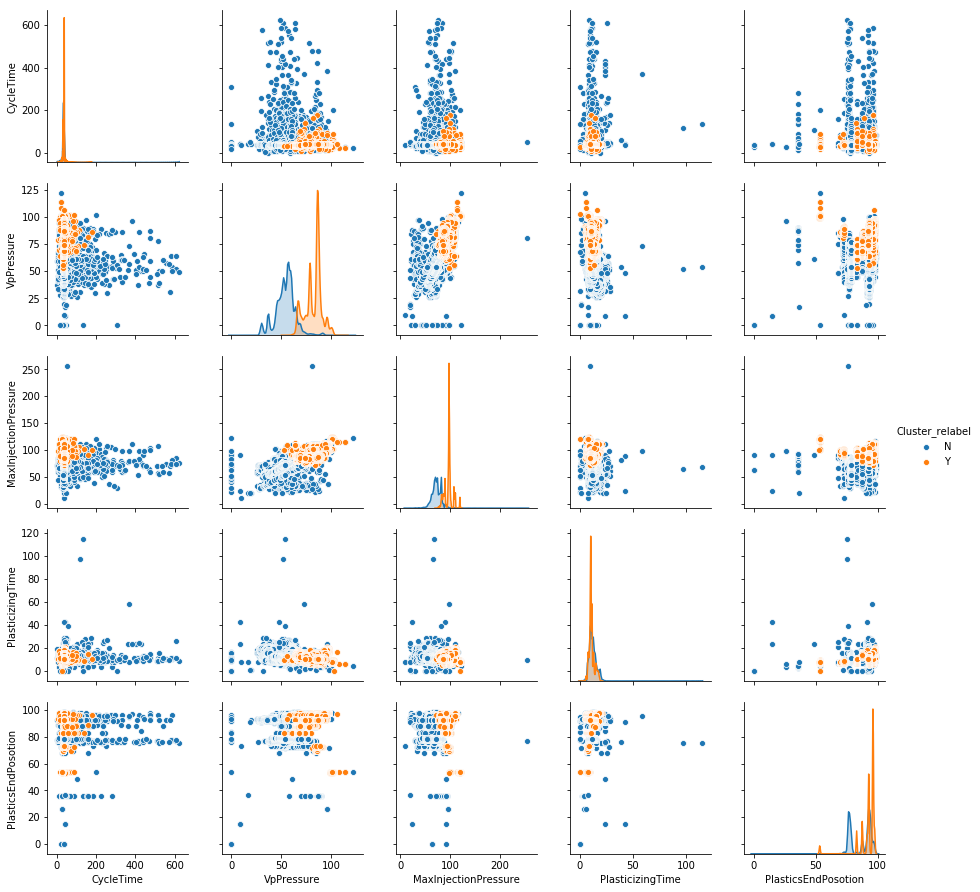

In [49]:
# scatterplot matrix by plotly with box plot at diagonal & different color by index(GROUP)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plot_label = 'Cluster_relabel'
fs_cols_ = rfe_cols + [plot_label]

g = sns.pairplot(isee_machine_operation[fs_cols_],
             hue = plot_label
            )

# plt.show()
# fig.savefig('./result/isee_machine/scatter.png')

### 클러스터링 group별로  평균/최대/최소값 구하기
- group > 초기중기말기라벨(Operation_label) , 클러스터링군집 Re라벨(Cluster_relabel)

In [6]:
group_label = ['Operation_label','Cluster_relabel']

data = isee_machine_operation[rfe_cols+group_label]
data['Operation_label'] = data['Operation_label'].replace({0:'0:초기',1:'1:중기',2:'2:말기'})
cluster_group_describe = data.groupby(group_label)[rfe_cols].describe()

NameError: name 'rfe_cols' is not defined

In [11]:
isee_machine_operation

,ModuleCount,creationTime,CycleTime,VpPosition,VpTime,VpPressure,MaxInjectionPressure,InjectionEndPosition,PlasticizingTime,PlasticsEndPosotion,...,機台號,拉長,工單號,產品編號,產品名稱,模號,CycleNum,creationTime_diff,Operation_label,True_label
9,270422,2018-09-02 13:46:00,40.47,25.0,3.63,63,76,17.7,10.23,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
10,270423,2018-09-02 13:46:00,40.47,25.0,3.62,63,76,17.3,10.43,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,0.0,1,N
11,270424,2018-09-02 13:47:00,40.47,25.0,3.64,64,77,23.0,10.57,97.5,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
12,270425,2018-09-02 13:48:00,40.47,25.0,3.63,63,79,17.3,10.86,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
13,270426,2018-09-02 13:48:00,40.47,25.0,3.62,62,79,15.4,11.20,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,0.0,1,N
14,270427,2018-09-02 13:49:00,40.47,25.0,3.62,63,80,17.2,11.05,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
15,270428,2018-09-02 13:50:00,40.47,25.0,3.63,62,80,16.3,11.10,97.5,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
16,270429,2018-09-02 13:50:00,40.47,25.0,3.62,63,81,16.8,11.36,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,0.0,1,N
17,270430,2018-09-02 13:51:00,40.47,25.0,3.62,64,82,17.5,11.07,97.3,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N
18,270431,2018-09-02 13:52:00,40.47,25.0,3.62,62,81,15.8,11.41,97.4,...,C23,罗彩凤,MX18072710-R,PL04496-03040,12-71464-1049_A HOLSTER TIMELESS-2 BLACK 黑色硬膠滑套-R,21-54140,3,60.0,1,N


In [13]:
group_label = ['Operation_label','True_label']

data = isee_machine_operation[list(X_all.columns)+group_label]
data['Operation_label'] = data['Operation_label'].replace({0:'0:초기',1:'1:중기',2:'2:말기'})
cluster_group_describe = data.groupby(group_label)[list(X_all.columns)].describe()

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [51]:
cluster_group_describe

CycleTime                                    \
                                    count       mean       std   min    25%   
Operation_label Cluster_relabel                                               
1:중기            N                211080.0  35.341773  8.596023  0.00  32.87   
                Y                 22613.0  36.404768  3.829524  5.22  33.76   

                                                      VpPressure             \
                                   50%    75%     max      count       mean   
Operation_label Cluster_relabel                                               
1:중기            N                34.83  37.42  622.04   211080.0  54.345002   
                Y                37.85  38.51  177.21    22613.0  82.585637   

                                 ... PlasticizingTime          \
                                 ...              75%     max   
Operation_label Cluster_relabel  ...                            
1:중기            N                ...            14.18  114.80   
                Y                ...            11.93   21.21   

                                PlasticsEndPosotion                       \
                                              count       mean       std   
Operation_label Cluster_relabel                                            
1:중기            N                          211080.0  86.782861  8.052828   
                Y                           22613.0  92.564653  7.400955   

                                                               
                                  min   25%   50%   75%   max  
Operation_label Cluster_relabel                                
1:중기            N                 0.0  77.7  91.5  93.7  98.7  
                Y                52.9  92.6  96.2  96.3  98.0  

[2 rows x 40 columns]

In [40]:
# cluster_group_describe.to_excel('./output/cluster_group_describe_190530_dbscan.xlsx')